## Purpose
Validate the structure of data especially the comments for which I was unable to find data dictionary and had to validate guesses about its structure.

### References

* Chatbot with TF: https://chatbotsmagazine.com/contextual-chat-bots-with-tensorflow-4391749d0077
* Good reference list for reading: http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/
* **Chameleon paper:**http://www.cs.cornell.edu/~cristian/papers/chameleons.pdf
* **Pandas pipelines:**https://medium.com/bigdatarepublic/integrating-pandas-and-scikit-learn-with-pipelines-f70eb6183696


### Options:
* Use categories from semtype tagging to identify

## Initialize

In [5]:
# Utility
import sys,os
import time

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) # more columns displayed at once
pd.options.display.max_colwidth = 200 # more of the text displayed at once

# Custom
from processing import tag_utterances
from processing import load_sem_types
from processing import DataPipeline

# Set path for importing data
data_instance = DataPipeline(comments_path = '../data/reddit_comments_askDocs_2014_to_2018_03.gz',
                            posts_path = '../data/original_posts_under_askDocs_subreddit_id.gz')

## NLP
import spacy

In [31]:
# Take a look at the columns
df.columns.tolist()

['body',
 'score_hidden',
 'archived',
 'name',
 'author',
 'author_flair_text',
 'downs',
 'created_utc',
 'subreddit_id',
 'link_id',
 'parent_id',
 'score',
 'retrieved_on',
 'controversiality',
 'gilded',
 'id',
 'subreddit',
 'ups',
 'distinguished',
 'author_flair_css_class',
 'removal_reason',
 'is_clinician',
 'tokenized_sents']

In [2]:
path_to_data = '../data/reddit_comments_askDocs_2014_to_2018_03.gz'
df = pd.read_csv(path_to_data,dtype={'body':str,'score_hidden':float})
print('Shape',df.shape)
df.head(2)

Shape (557648, 21)


/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,"for a manlet such as yourself I'd recommend at least 70 oz of water daily and at least 7 hours of sleep. Cut down on red meat, smoking, and sodium intake and check back in a few days.",NaN,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,t3_7k5x2h,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,NaN,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,t1_cwcf958,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN


**Using ETL Loaded Functions**

In [6]:
df = data_instance.load_full_thread()
import numpy as np
print('Turns in conversation for combined posts')
v = df['link_id_short'].value_counts().values
print('mean:', np.mean(v))
print('median:', np.median(v) )
print('min:',min(v))
print('max:',max(v))
print('Count of where turns equals 2:',sum(v==2))

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)
Turns in conversation for combined posts
mean: 4.543633995441224
median: 4.0
min: 2
max: 106
Count of where turns equals 2: 7843


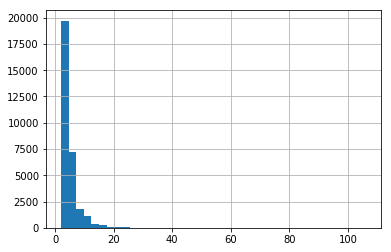

In [7]:
# distribution of turns
import matplotlib.pyplot as plt
%matplotlib inline
df['link_id_short'].value_counts().hist(bins=40);

In [9]:
thread_start_count = df[df['is_thread_start']==1]['body'].apply(lambda r: len(str(r).split()))
print('Mean num words for thread start:',np.mean(thread_start_count))
nonthread_start_count = df[df['is_thread_start']==0]['body'].apply(lambda r: len(str(r).split()))
print('Mean num words for non-thread start:',np.mean(nonthread_start_count))

Mean num words for thread start: 170.70797785737545
Mean num words for non-thread start: 47.11861245118309


In [14]:
print('Number of users',len(set(df['author'])))
print('Global mean number of posts per user',len(df)/len(set(df['author'])))

Number of users 26353
Global mean number of posts per user 5.294843091868098


In [13]:
df.shape

(139535, 28)

## Data Dictionary:
Original post can be seen with the link_id
* **link_id** Link to the page where the original thread was started
    * **id** A posts id. The only reason this may not be unique
    * **parent_id** These ids are pointing back towards the original post and represent a new comment that is replying directly towards the original posting. Can be considered a general comment. I.e. All posts with the same parent_id (following the "_") as the link_id are. E.g. If the link_id is "t3_827pgt", all parent_id's with "827pgt" are pointing towards that original post.

* **subreddit_id** and **subreddit** Irrelevant


### Documentation:
* Figuring out how to organize a reply and response is tricky:
    * On one hand, the people asking the questions should be the non-clinician folks and the clinicians answering the questions. But it is a community forum so people can chime in with ''answers'' whenever. Ansd they might be correct.
     *  Also, it is likely that clinicians will ask follow-up questions if it is more debate than answer so perhaps drilling down into a solution
     * This latest point gets at how to utilize the id's and parent_ids
     
* <b>There are 2 reasonably straightforward ways of getting to the reply/response//question/answer pairs:</b>
    * 1) Treat each main post as the 1 question (then randomly select 1 response or have each comment in that thread be a response to the same question repeated for each response
    * 2) Treat each id (starting with the original thread) as the question and each subsequent post that has that id as its parent (**i.e. parent_id**)

In [ ]:
print('Number of rows:',df.shape[0])
print('Number of unique posters:',len(df.author.unique()))
print()
print('Number of link_ids:',len(df.link_id.unique()))
print('Number of parent_ids:',len(df.parent_id.unique()))
print('Number of ids:',len(df.id.unique()))

In [ ]:
print('Proportion of unique links to num rows:',len(df['link_id'].unique())/df.shape[0])
print('Proportion of unique ids to num rows:',len(df['id'].unique())/df.shape[0])
print('Proportion of unique parent ids to num rows:',len(df['parent_id'].unique())/df.shape[0])

## Medical Entity Extraction with UMLS

In [1]:
# UMLS
# Set absolute path the QuickUMLS Server
abs_path_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS'
abs_path_data_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS/QuickUMLS_db'
sys.path.append(abs_path_umls+'/QuickUMLS')
from quickumls import QuickUMLS
tagger = QuickUMLS(abs_path_data_umls)

NameError: name 'sys' is not defined

In [3]:
# Load semantic types
sem_type_dict = load_sem_types('../data/SemGroups_2013.txt')

In [4]:
t = tagger.nlp(df['body'].iloc[4])
t.text

"She's had it for 8 months, we've never had any issues with it before."

In [7]:
t = tagger.nlp(t.text)

s = t
matches= tagger.match(s, best_match=True, ignore_syntax=False)
for match in matches:
    dir(match)
    print(match,'\n')
for m in match:
    print(m)

[{'start': 19, 'end': 25, 'ngram': 'months', 'term': 'month', 'cui': 'C1561542', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}] 

[{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C0033213', 'similarity': 0.75, 'semtypes': {'T033'}, 'preferred': 1}, {'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C1706387', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}] 

{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C0033213', 'similarity': 0.75, 'semtypes': {'T033'}, 'preferred': 1}
{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C1706387', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}


In [21]:
sd = load_sem_types('../data/SemGroups_2013.txt')


AttributeError: 'set' object has no attribute 'text'

In [11]:
import importlib
from processing import tag_utterances
from processing import load_sem_types

tag_utterances(1, t.text, tagger)

{'T170'}


[[1, 19, 25, 'month', 'C1561542', 0.75, {'Intellectual Product'}]]

In [8]:
df.shape

(557648, 21)

In [9]:
%%time
print('Iterating over every document')
#Iterate over every document and extract the concepts
i=-1        
result = []
for idx,doc in  enumerate(df['body']):

    if idx % 10000 == 0:
        print("Documents processed: {}".format(idx))
    try:
        i+=1
        annotations = tag_utterances(i,doc,tagger)
        result.extend(annotations)
    except Exception as e:
        print(e)
        
df_matches = pd.DataFrame(data=result, columns =['document','start','end','term','cui','similarity','semtypes'])
df_matches.sort_values(by=['document','start'],inplace=True)

Iterating over every document
Documents processed: 0
Documents processed: 10000
Documents processed: 20000
Documents processed: 30000
Documents processed: 40000
Documents processed: 50000
Argument 'string' has incorrect type (expected str, got float)
Documents processed: 60000
Documents processed: 70000
Argument 'string' has incorrect type (expected str, got float)
Documents processed: 80000
Documents processed: 90000
Documents processed: 100000
Documents processed: 110000
Documents processed: 120000
Argument 'string' has incorrect type (expected str, got float)
Documents processed: 130000
Documents processed: 140000
Documents processed: 150000
Documents processed: 160000
Documents processed: 170000
Documents processed: 180000
Documents processed: 190000
Argument 'string' has incorrect type (expected str, got float)
Documents processed: 200000
Argument 'string' has incorrect type (expected str, got float)
Argument 'string' has incorrect type (expected str, got float)
Documents processe

KeyboardInterrupt: 

In [6]:
df.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,for a manlet such as yourself I'd recommend at...,NaN,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,...,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,NaN,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,...,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN
2,Never been tested for that. I was hoping the ...,NaN,NaN,NaN,-o2,This user has not yet been verified.,NaN,1461952470,t5_2xtuc,t3_4gz1fi,...,1,1.463777e+09,0,0,d2mce34,AskDocs,1.0,NaN,default,NaN
3,"She said her constant abdominal pain is a 6, t...",NaN,NaN,NaN,05P,This user has not yet been verified.,NaN,1504214332,t5_2xtuc,t3_6x9jk0,...,1,1.504553e+09,0,0,dme9lzr,AskDocs,NaN,NaN,default,NaN
4,"She's had it for 8 months, we've never had any...",NaN,NaN,NaN,05P,This user has not yet been verified.,NaN,1504217835,t5_2xtuc,t3_6x9jk0,...,1,1.504554e+09,0,0,dmecohs,AskDocs,NaN,NaN,default,NaN


### Data Journal

* **Creating training data**
    * A lot of decisions have to be made when creating the conversational data. We could just give line by line
    * Even deciding what an utterance is can be difficult. Is it split by sentence? Do we assume that people are going to be generally giving one answer?
    * Should the title or actual post be used as the query?